$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield


\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np

from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

### Feedback linearization of the control-affine dynamics

We attempt to stabilize the system to the origin, that is, drive $q$ to $0$. We'll use the normal form transformation:

\begin{equation}
    \bs{\Phi}(\mb{q}, \dot{\mb{q}}) = \bs{\eta}(\mb{q}, \dot{\mb{q}}) = \begin{bmatrix} \mb q \\ \mb{\dot{q}} \end{bmatrix}.
\end{equation}

In [2]:
from core.dynamics import ConfigurationDynamics

class FiniteDimKoopSysOutput(ConfigurationDynamics):
    def __init__(self, finite_dim_koop_sys):
        ConfigurationDynamics.__init__(self, finite_dim_koop_sys, 2)
        self.finite_dim_koop_sys = finite_dim_koop_sys
    
    def y(self, q):
        return q
        
    def dydq(self, q):
        return np.array([[1, 0], [0, 1]])
    
    def d2ydq2(self, q):
        return np.zeros((1, 2, 2))
    
output = FiniteDimKoopSysOutput(finite_dim_koop_sys)

In [3]:
from core.controllers import FBLinController, LQRController
q, r = 5, 1
Q_fb = q * np.identity(4)
R_fb = r*np.identity(2)
lqr = LQRController.build(output, Q_fb, R_fb)
fb_lin = FBLinController(output, lqr)

In [4]:
x_0 = np.array([3, 3, -3, 3])
ts = np.linspace(0, 5, 500 + 1)

xs_fb, us_fb = finite_dim_koop_sys.simulate(x_0, fb_lin, ts)

### Koopman Canonical Transform of the Control-Affine Dynamics

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    1
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have:

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \\ 0 \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with

\begin{equation}
F = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \lambda & 0 & 0 & 0\\
0 & 0 & 0 & \mu & 0 & 0\\
0 & 0 & 0 & 0 & 2 \lambda & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & -\frac{1}{\lambda}\\
0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & -2c & 0 & 0 & 0\\
0 & 0 & 2 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 &  0 & 0 & 0 & 0\\
-\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0 & -\frac{1}{\mu}\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & \frac{1}{\lambda} & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [5]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0],
              [0, 0, lambd, 0, 0, 0],
              [0, 0, 0, mu, 0, 0],
              [0, 0, 0, 0, 2*lambd, 0],
              [0, 0, 0, 0, 0, 0]])
G_1 = np.array([[0, 0, 0, 0, 0, -1/lambd],
                [0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0, 0],
                [0, 0, 0, 0, 0, 1], 
                [0, 0, -2*c, 0, 0, 0], 
                [0, 0, 2, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/mu, 0, -1/(lambd*mu), 0, 0, -1/mu],
                [0, 0, 0, 0, 0, 0], 
                [1, 0, 1/lambd, 0, 0, 1], 
                [0, 0, 0, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([x[0] - 1/lambd*x[2],
                            x[1] - 1/mu*x[3] + (2*lambd - mu)*c/(2*lambd*mu)*x[2]**2,
                            x[2], 
                            x[3] - c*x[2]**2, 
                            x[2]**2, 
                            1])
C_h = np.array([[1, 0, 1/lambd, 0, 0, 0],
                [0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu), 0]])
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C_h, phi_fun)

With the same objective as before, we aim to design a feedback linearizing control law utilizing the bilinear dynamics. 
We assume that the outputs can be linearly described in the lifted state space such that $\mb y = C^{\mb h} \mb z$. 
The outputs encoding the objective (driving the system to the origin) can then be described as

\begin{equation}
    \bs{\eta}(\mb{q}, \dot{\mb{q}}) = C^{\mb h} \mb z - \mb y_d(t), 
    \qquad C^{\mb h} = \begin{bmatrix} 1 & 0 & \frac{1}{\lambda} & 0 & 0 & 0\\
    0 & 1 & 0 & \frac{1}{\mu} & \frac{c}{\mu} - \frac{(2\lambda - \mu)c}{2\lambda \mu} & 0
    \end{bmatrix}
\end{equation}

To verify that the transformation is correct, we compare the open loop simulation of the true system and the transformed 
system.

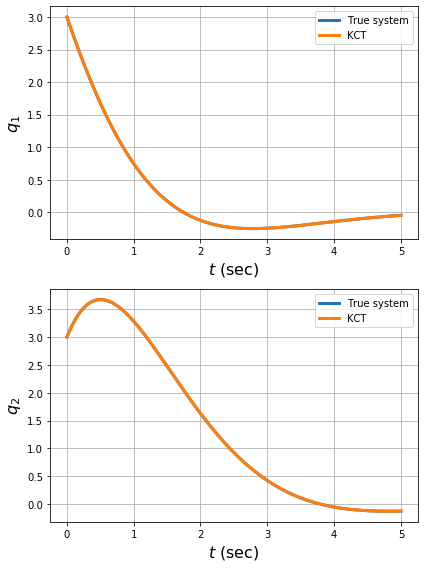

In [6]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(koop_bilinear_sys, us_fb, ts[:-1])
z_0 = phi_fun(x_0)
zs_koop, us_koop = koop_bilinear_sys.simulate(z_0, ol_controller, ts)
xs_koop = np.dot(C_h, zs_koop.T)

_, axs = subplots(2, 1, figsize=(6, 8))
ylabels = ['$q_1$', '$q_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), xs_fb.T, xs_koop, ylabels):
    ax.plot(ts, data_fb, linewidth=3, label='True system')
    ax.plot(ts, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

Differentiating the outputs we get and writing the actuated dynamics $G_1 \mb z u_1 + G_2 \mb z u_2$ as $\hat{G}(\mb z) \mb u$ we get:

\begin{equation}
    \bs{\dot{\eta}} = C^{\mb h}\mb{\dot{z}} - \mb{\dot{y}}_d(t) = C^{\mb h} \big (\mb{\dot{z}} - \mb{\dot{z}}_d(t) \big ) = C^{\mb h} \big ( F \mb z + \hat{G}(\mb z)\mb u - \mb{\dot{z}}_d \big ).
\end{equation}

Because of the relative degree assumption on the outputs, each output $y_i(\mb x)=h_i(\mb x), i=1,\dots,k$ has relative degree 2,
we have that $L_g h(x) = C^{\mb h} \hat{G}(\mb z) = 0$. As a result, $\bs{\dot{\eta}} = C^{\mb h} \big ( F \mb z - \mb{\dot{z}}_d \big )$.
Now, akin to classical feedback linearization we differentiate the outputs again to get:

\begin{equation}
    \bs{\ddot{\eta}} = C^{\mb h} \big ( F \mb{\dot{z}} - \mb{\ddot{z}}_d \big ) = C^{\mb h} \big ( F(F \mb z + \hat{G}(\mb z)\mb u)- \mb{\ddot{z}}_d \big )
    = C^{\mb h} \big ( F^2 \mb z + F\hat{G}(\mb z)\mb u - \mb{\ddot{z}}_d \big )
\end{equation}

Now, the output error dynamics can be written in normal form such that we get:

\begin{equation}
    \bs{\Phi}(\mb{q}, \dot{\mb{q}}) = \begin{bmatrix} \bs{\eta}(\mb{q}, \dot{\mb{q}})\\ \bs{\dot{\eta}}(\mb{q}, \dot{\mb{q}})\end{bmatrix}, \qquad
    \bs{\dot{\Phi}} = \begin{bmatrix} \bs{\dot{\eta}}\\ \bs{\ddot{\eta}}\end{bmatrix} =
    \begin{bmatrix} \bs{\dot{\eta}}\\
    C^{\mb h} \big ( F(F \mb z + \hat{G}(\mb z)\mb u)- \mb{\ddot{z}}_d \big ) \end{bmatrix}
\end{equation}

In [7]:
from core.dynamics.configuration_dynamics import ConfigurationDynamics

class BilinearSysOutput(ConfigurationDynamics):
    def __init__(self, bilinear_dynamics, C_h):
        ConfigurationDynamics.__init__(self, bilinear_dynamics, 1)
        self.bilinear_dynamics = bilinear_dynamics
        self.C_h = C_h
    
    def y(self, x):
        z = self.bilinear_dynamics.phi_fun(x)
        return np.dot(self.C_h, z)
        
    def dydx(self, x):
        return np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
    
    def d2ydz2(self, x):
        return np.zeros((1, self.k, 4))

    def y_d(self, t):
        return np.dot(self.C_h, self.z_d(t))

    def y_d_dot(self, t):
        return np.dot(self.C_h, self.z_d_dot(t))

    def y_d_ddot(self, t):
        return np.dot(self.C_h, self.z_d_ddot(t))
    
    def z_d(self, t):
        return np.array(([0, 0, 0, 0, 0, 1]))

    def z_d_dot(self, t):
        return np.zeros(self.bilinear_dynamics.n)

    def z_d_ddot(self, t):
        return np.zeros(self.bilinear_dynamics.n)
    
output_bl_fb = BilinearSysOutput(koop_bilinear_sys, C_h)

### Koopman Feedback Linearization


Since the unactuated dynamics are already linear in the lifted state space, we only need to cancel out the nonlinear actuated 
dynamics terms. Writing the actuated dynamics $G \mb z u$ as $\hat{G}(\mb z) u$ we get the control law:

\begin{equation}
    \mb u(\mb z, t) = \big(C^{\mb h}F\hat{G}(\mb z)\big )^\dagger (\mb{\ddot{z}}_d(t) - C^{\mb h}F^2 \mb z_d(t) + C^{\mb h}\bs{\nu}(\mb z, t)),
\end{equation}

where $\bs{\nu}(\mb z, t)$ is a controller designed with LQR to stabilize the system 

\begin{equation}
\dot{\Phi}_{\mb z} = \begin{bmatrix} 0 & I \\ F^2 & 0\end{bmatrix} \Phi_{\mb z} + 
\begin{bmatrix} 0 \\ I \end{bmatrix} \bs{\nu}
\end{equation}


In [8]:
from scipy.linalg import solve_continuous_are
from koopman_core.controllers.bilinear_fb_lin_controller import BilinearFBLinController

f_eta = np.concatenate((np.zeros((n_koop,n_koop)), np.eye(n_koop)), axis=1)
f_eta_dot = np.concatenate((F@F, np.zeros((n_koop,n_koop))), axis=1)
F_lin = np.concatenate((f_eta, f_eta_dot), axis=0)
G_lin = np.concatenate((np.zeros((n_koop,n_koop)), np.eye(n_koop)), axis=0)
Q_bl_fb = q*np.eye(2*n_koop)
R_bl_fb = r*np.eye(n_koop)
P = solve_continuous_are(F_lin, G_lin, Q_bl_fb, R_bl_fb)
K = -np.linalg.inv(R_bl_fb)@G_lin.T@P
bl_fb_lin = BilinearFBLinController(koop_bilinear_sys, output_bl_fb, K)

In [9]:
xs_bl_fb, us_bl_fb = finite_dim_koop_sys.simulate(x_0, bl_fb_lin, ts)

### Performance comparison of the control-affine and Koopman bilinear controllers

To compare the relative performance of the feedback linearizing controller based on the control-affine dynamics
and the feedback linearizing controller based on the Koopman bilinear dynamics, consider the quadratic cost metric,
where $Q, R$ are the cost matrices used for the LRQ design of the linear auxillary controller:

\begin{equation}
    J(\mb x, \mb u, t) = \int_{0}^{T_f} \big [ (\mb y(t) - \mb y_d(t))^T Q (\mb y(t) - \mb y_d(t)) + \mb u(t)^T R \mb u(t) \big ] dt
\end{equation}

Recall that in this example the output is simply $y(t) = q$ that we aim to stabilize to the origin.

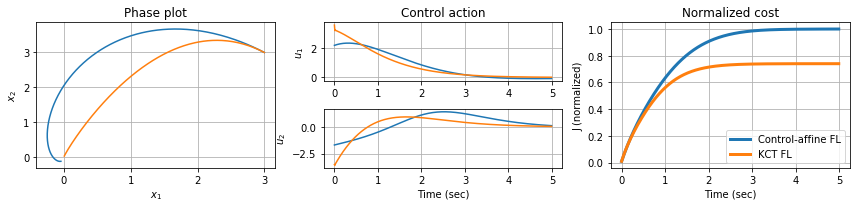

In [10]:
import matplotlib.pyplot as plt
import matplotlib

cost_fb_lin = np.cumsum(np.diag(xs_fb[1:,:] @ Q_fb @ xs_fb[1:,:].T) + np.diag(us_fb @ R_fb @ us_fb.T))
cost_bl_fb_lin = np.cumsum(np.diag(xs_bl_fb[1:,:] @ Q_fb @ xs_bl_fb[1:,:].T) + np.diag(us_bl_fb @ R_fb @ us_bl_fb.T))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(xs_fb[:,0], xs_fb[:,1], label='Control-affine FL')
plt.plot(xs_bl_fb[:,0], xs_bl_fb[:,1], label='KCT FL')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Phase plot')
plt.grid()

plt.subplot(2,3,2)
plt.plot(ts[:-1], us_fb[:,0], label='Control-affine FL')
plt.plot(ts[:-1], us_bl_fb[:,0], label='KCT FL')
plt.ylabel('$u_1$')
plt.title('Control action')
plt.grid()

plt.subplot(2,3,5)
plt.plot(ts[:-1], us_fb[:,1], label='Control-affine FL')
plt.plot(ts[:-1], us_bl_fb[:,1], label='KCT FL')
plt.xlabel('Time (sec)')
plt.ylabel('$u_2$')
plt.grid()

plt.subplot(1,3,3)
plt.plot(ts[:-1], cost_fb_lin/cost_fb_lin[-1], linewidth=3, label='Control-affine FL')
plt.plot(ts[:-1], cost_bl_fb_lin/cost_fb_lin[-1], linewidth=3, label='KCT FL')
plt.xlabel('Time (sec)')
plt.ylabel('J (normalized)')
plt.title('Normalized cost')
plt.grid()
plt.legend(loc='lower right')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig('examples/figures/finite_koop_sys.pdf', format='pdf', dpi=2400)
plt.show()

### Linear model predictive control

In [11]:
import scipy as sc
from koopman_core.controllers.linear_mpc_controller import LinearMpcController

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
C_lin = np.eye(n)
D_lin = np.zeros((n,m))
dt = 1e-2
lin_sys = sc.signal.StateSpace(A_lin, B_lin, C_lin, D_lin)
lin_sys_d = lin_sys.to_discrete(dt)
A_d, B_d, C_d, D_d = lin_sys_d.A, lin_sys_d.B, lin_sys_d.C, lin_sys_d.D

# MPC parameters:
umax = np.array([100., 100.])
umin = -umax
xmax = np.array([10., 10., 10., 10.])
xmin = -xmax
Q_mpc = Q_fb
R_mpc = R_fb
n_pred = 100
set_pt = np.zeros(n)

mpc_controller = LinearMpcController(n, m, n_koop, n_pred, lin_sys_d, xmin, xmax, umin, umax, Q_mpc, Q_mpc, R_mpc, set_pt)
mpc_controller.construct_controller()
xs_mpc, us_mpc = finite_dim_koop_sys.simulate(x_0, mpc_controller, ts)

### Koopman feedback linearized model predictive control

In [12]:
import scipy as sc
from koopman_core.controllers.bilinear_mpc_controller import BilinearMpcController

C_bl= np.eye(int(2*n_koop))
D_bl = np.zeros((int(2*n_koop),n_koop))
dt = 1e-2
fb_sys = sc.signal.StateSpace(F_lin, G_lin, C_bl, D_bl)
fb_sys_d = fb_sys.to_discrete(dt)
A_bl_d, B_bl_d = fb_sys_d.A, fb_sys_d.B

# MPC parameters:
umax = np.array([100., 100.])
umin = -umax
xmax = np.array([10., 10., 10., 10.])
xmin = -xmax
k = m
Q_mpc = Q_bl_fb
R_mpc = R_bl_fb
C_stacked = np.zeros((int(2*k), int(2*n_koop)))
C_stacked[:k, :n_koop] = C_h
C_stacked[k:, n_koop:] = C_h
#Q_mpc = C_stacked.T@Q_fb@C_stacked
#R_mpc = C_h.T@R_fb@C_h
n_pred = 250
set_pt = np.zeros(n)

bl_mpc_controller = BilinearMpcController(n, m, k, n_koop, n_pred, fb_sys_d, koop_bilinear_sys, xmin, xmax, umin, umax, Q_mpc, Q_mpc, R_mpc, set_pt)
bl_mpc_controller.construct_controller()
xs_bl_mpc, us_bl_mpc = finite_dim_koop_sys.simulate(x_0, bl_mpc_controller, ts)

TypeError: __init__() missing 2 required positional arguments: 'R' and 'set_pt'

### Performance comparison of the control-affine and Koopman bilinear controllers

To compare the relative performance of the feedback linearizing controller based on the control-affine dynamics 
and the feedback linearizing controller based on the Koopman bilinear dynamics, consider the quadratic cost metric,
where $Q, R$ are the cost matrices used for the LRQ design of the linear auxillary controller:

\begin{equation}
    J(\mb x, \mb u, t) = \int_{0}^{T_f} \big [ (\mb y(t) - \mb y_d(t))^T Q (\mb y(t) - \mb y_d(t)) + \mb u(t)^T R \mb u(t) \big ] dt
\end{equation}

Recall that in this example the output is simply $y(t) = q$ that we aim to stabilize to the origin.

In [ ]:
cost_fb_lin = np.cumsum(np.diag(xs_fb[1:,:] @ Q_fb @ xs_fb[1:,:].T) + np.diag(us_fb @ R_fb @ us_fb.T))
cost_bl_fb_lin = np.cumsum(np.diag(xs_bl_fb[1:,:] @ Q_fb @ xs_bl_fb[1:,:].T) + np.diag(us_bl_fb @ R_fb @ us_bl_fb.T))
#cost_mpc_lin = np.cumsum(np.diag(xs_mpc[1:,:] @ Q_fb @ xs_mpc[1:,:].T) + np.diag(us_mpc @ R_fb @ us_mpc.T))
cost_bl_mpc = np.cumsum(np.diag(xs_bl_mpc[1:,:] @ Q_fb @ xs_bl_mpc[1:,:].T) + np.diag(us_bl_mpc @ R_fb @ us_bl_mpc.T))

_, axs = subplots(2, 2, figsize=(12, 8))
ylabels = ['$q$', '$\\dot{q}$']

#for ax, data_fb, data_bl_fb, data_mpc, data_bl_mpc, ylabel in zip(axs[:-1].flatten(), xs_fb.T, xs_bl_fb.T, xs_mpc.T, xs_bl_mpc.T, ylabels):
for ax, data_fb, data_bl_fb, data_bl_mpc, ylabel in zip(axs[:-1].flatten(), xs_fb.T, xs_bl_fb.T, xs_bl_mpc.T, ylabels):
    ax.plot(ts, data_fb, linewidth=3, label='Control-affine')
    ax.plot(ts, data_bl_fb, linewidth=3, label='Koopman bilinear')
    #ax.plot(ts, data_mpc, linewidth=3, label='Linear MPC')
    ax.plot(ts, data_bl_mpc, linewidth=3, label='Bilinear MPC')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()

ax = axs[1,0]
ax.plot(ts[:-1], us_fb[:,0], linewidth=3, label='$u_1$, control-affine')
ax.plot(ts[:-1], us_fb[:,1], linewidth=3, label='$u_2$, control-affine')
ax.plot(ts[:-1], us_bl_fb[:,0], linewidth=3, label='$u_1$, Koopman bilinear')
ax.plot(ts[:-1], us_bl_fb[:,1], linewidth=3, label='$u_2$, Koopman bilinear')
#ax.plot(ts[:-1], us_mpc[:,0], linewidth=3, label='$u_1$, linear MPC')
#ax.plot(ts[:-1], us_mpc[:,1], linewidth=3, label='$u_2$, linear MPC')
ax.plot(ts[:-1], us_bl_mpc[:,0], linewidth=3, label='$u_1$, bilinear MPC')
ax.plot(ts[:-1], us_bl_mpc[:,1], linewidth=3, label='$u_2$, bilinear MPC')
ax.grid()
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$u$', fontsize=16)
ax.legend()

ax = axs[1,1]
ax.plot(ts[:-1], cost_fb_lin/cost_fb_lin[-1], linewidth=3, label='Control-affine')
ax.plot(ts[:-1], cost_bl_fb_lin/cost_fb_lin[-1], linewidth=3, label='Koopman bilinear')
#ax.plot(ts[:-1], cost_mpc_lin/cost_fb_lin[-1], linewidth=3, label='Linear MPC')
ax.plot(ts[:-1], cost_bl_mpc/cost_fb_lin[-1], linewidth=3, label='Bilinear MPC')
ax.grid()
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('Normalized cost, $J$', fontsize=16)
ax.legend(loc='lower right')
    
tight_layout()
show()